In [16]:
import os
import pandas as pd
import numpy as np

import gensim
from sklearn.decomposition import PCA

import opencorpora
from pymystem3 import Mystem
from many_stop_words import get_stop_words

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def lemm_and_filter(text, min_len=3, stopwords=get_stop_words('ru'), stem=Mystem(entire_input=False)):
    return ' '.join(list(filter(lambda word: word not in stopwords and len(word) > min_len, stem.lemmatize(text))))

In [3]:
reader = opencorpora.CorpusReader('tmp/annot.opcorpora.xml')
oc = pd.DataFrame([{
    'title': d.title(), 
    'text': d.raw(), 
    'categories': d.categories(),
    'lemmas': lemm_and_filter(d.raw())
} for d in reader.iter_documents() if len(d.raw()) >= 100])

In [4]:
phraser = gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(sentences=oc['lemmas'].str.split()))
oc['phrased'] = oc['lemmas'].str.split().map(lambda x: ' '.join(phraser[x]))

In [8]:
criminal_code = pd.read_csv('tmp/vectors/criminal_code.csv.gz', compression='gzip')
criminal_court_orders = pd.read_csv('tmp/vectors/criminal_court_orders.csv.gz', compression='gzip')
civil_code = pd.read_csv('tmp/vectors/civil_code.csv.gz', compression='gzip')
civil_court_orders = pd.read_csv('tmp/vectors/civil_court_orders.csv.gz', compression='gzip')

In [10]:
oc['source'] = 'opencorpora'
criminal_code['source'] = 'criminal_code'
criminal_court_orders['source'] = 'criminal_court_orders'
civil_code['source'] = 'civil_code'
civil_court_orders['source'] = 'civil_court_orders'

In [11]:
df = pd.concat([
    oc.reset_index()[['index', 'phrased', 'source']], 
    criminal_code.reset_index()[['index', 'phrased', 'source']],
    criminal_court_orders.reset_index()[['index', 'phrased', 'source']],
    civil_code.reset_index()[['index', 'phrased', 'source']],
    civil_court_orders.reset_index()[['index', 'phrased', 'source']],
]).reset_index(drop=True)

In [13]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(words=row['phrased'].split(), tags=[row.name])
documents = df.apply(td, axis=1).tolist()

In [ ]:
%%time
model = gensim.models.doc2vec.Doc2Vec()
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=500)

In [ ]:
if not os.path.exists('tmp/doc2vec/'):
    os.mkdir('tmp/doc2vec')
model.save('tmp/doc2vec/all_texts.model')

In [20]:
df['vectors'] = model.docvecs.vectors_docs.tolist()

In [21]:
df['pca'] = PCA(n_components=2).fit_transform(df['vectors'].tolist()).tolist()

In [31]:
from MulticoreTSNE import MulticoreTSNE

In [45]:
df['tsne'] = MulticoreTSNE(perplexity=30, n_iter=5000, n_jobs=16).fit_transform(np.array(df['vectors'].tolist())).tolist()

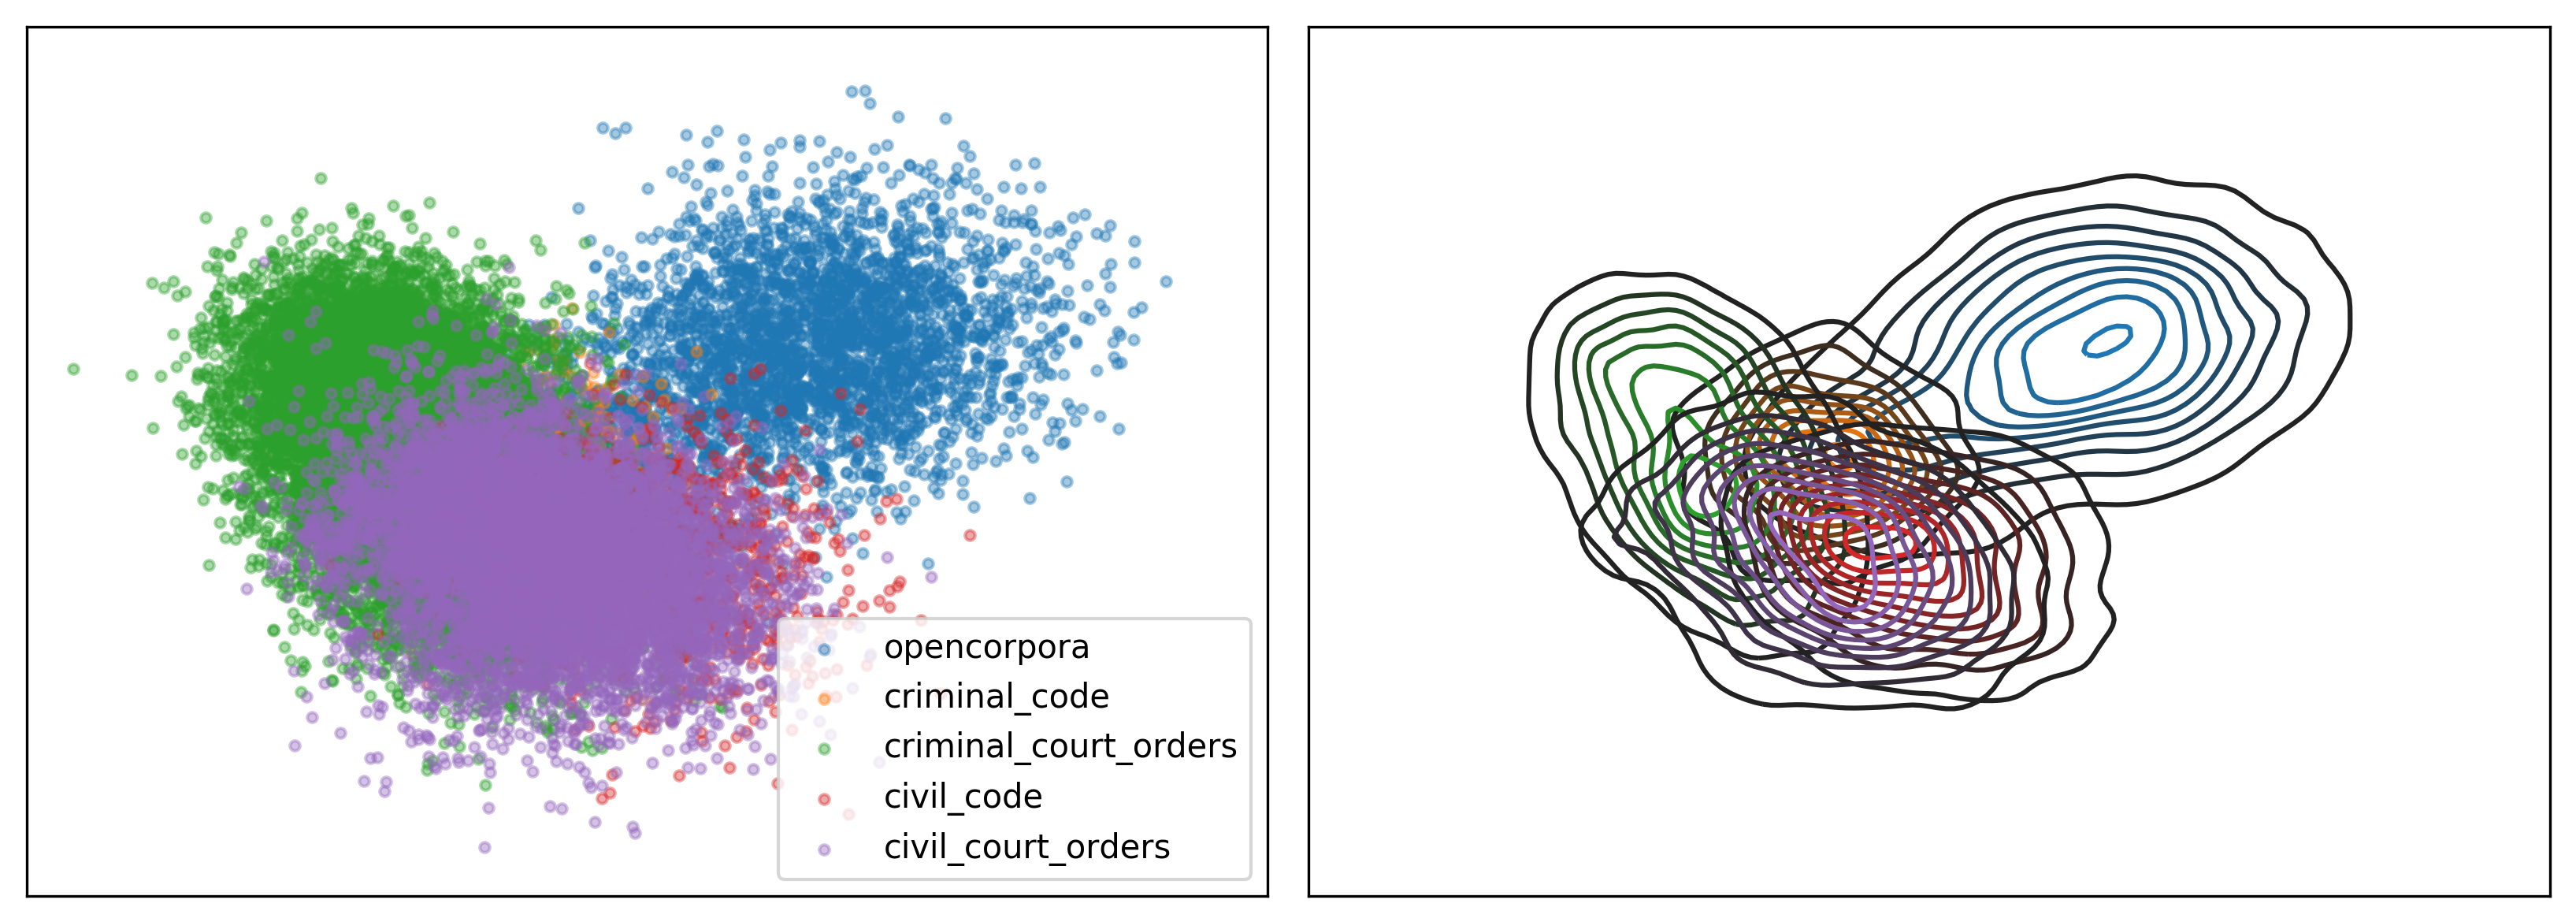

In [56]:
METHOD = 'pca'#'tsne'
DISPLAY = ['civil_court_orders', 'criminal_court_orders', 'opencorpora', 'criminal_code', 'civil_code']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), dpi=300, sharex='all', sharey='all')

for source in df['source'].unique():
    if source in DISPLAY:
        tmp = np.array(df[df['source'] == source][METHOD].tolist())
        ax1.scatter(tmp[:, 0], tmp[:, 1], marker='.', label=source, alpha=.4)
        ax2 = sns.kdeplot(tmp[:, 0], tmp[:, 1], ax=ax2, legend=False, shade_lowest=False)
        # ax2.text(-5, 8, "Court Orders", size=10, color='red')
    
ax1.legend()
ax1.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.autoscale()
plt.show()

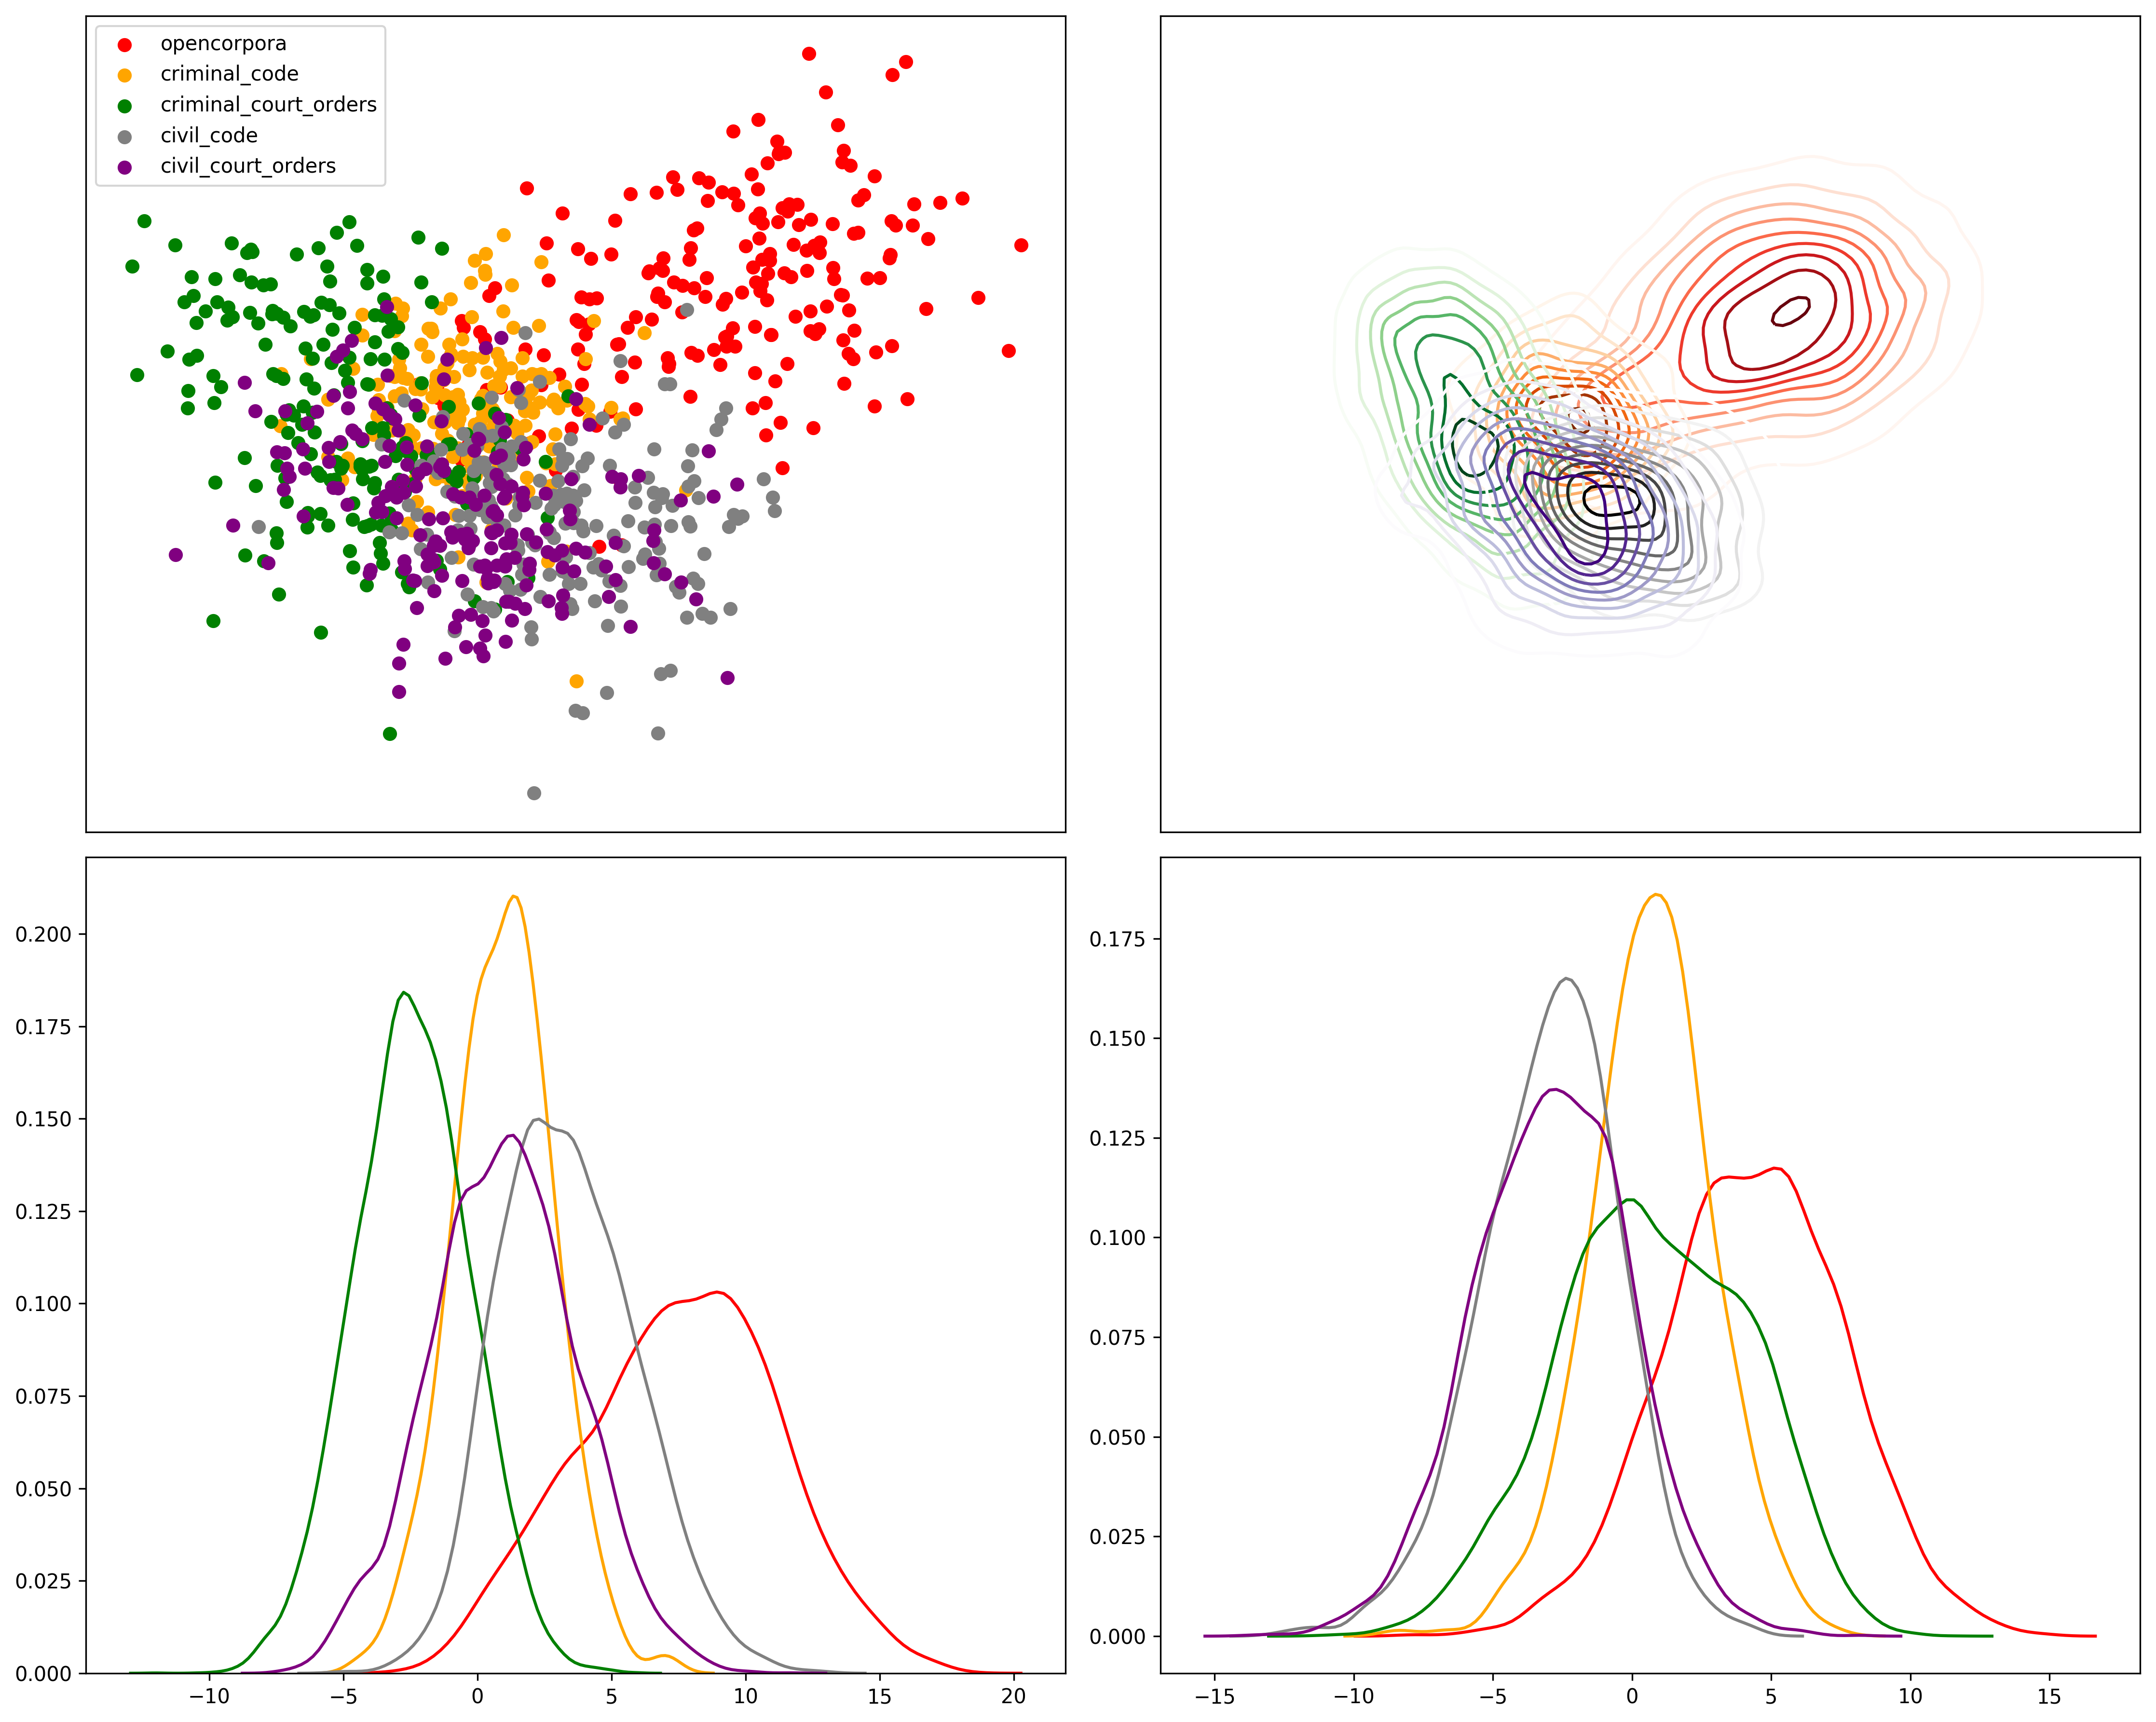

In [60]:
METHOD = 'pca'#'tsne'
DISPLAY = ['civil_court_orders', 'criminal_court_orders', 'opencorpora', 'criminal_code', 'civil_code']
SAMPLE_SIZE = 200

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), dpi=300)
disable_ticks = lambda x: x.tick_params(axis='both', which='both', left=False, bottom=False, 
                                        labelleft=False, labelbottom=False)

colors_iter = iter([
    ('red', 'Reds'),
    ('orange', 'Oranges'),
    ('green', 'Greens'), 
    ('gray', 'Greys'), 
    ('purple', 'Purples'), 
    ('blue', 'Blues'), 
])

for source_name in df['source'].unique():
    if source_name in DISPLAY:
        tmp = np.array(df[df['source'] == source_name][METHOD].tolist())
        tmp_sample = np.array(df[df['source'] == source_name].sample(SAMPLE_SIZE)[METHOD].tolist())
        color, colormap = next(colors_iter)
        ax1.scatter(tmp_sample[:, 0], tmp_sample[:, 1], label=source_name, c=color)
        sns.kdeplot(tmp[:, 0], tmp[:, 1], ax=ax2, shade=False, shade_lowest=False, cmap=colormap)
        sns.kdeplot(tmp[:,0], ax=ax3, color=color)
        sns.kdeplot(tmp[:, 1], ax=ax4, color=color)

ax1.legend()
ax3.legend()
disable_ticks(ax1)
disable_ticks(ax2)
plt.tight_layout()
plt.autoscale()
plt.show()

In [62]:
df.head()

,index,phrased,source,vectors,pca,tsne
0,0,школа_злословие учить прикусывать язык сохраня...,opencorpora,"[-5.208272933959961, -1.9861655235290527, -2.9...","[16.696305467708893, 4.670787565818735]","[28.24572739955284, -3.9712241517959685]"
1,1,последний восстание сеул международный биеннал...,opencorpora,"[-1.3897167444229126, 2.2787013053894043, -7.9...","[10.455934765133307, 5.5557667261261825]","[29.577336394171226, 3.889498997866135]"
2,2,отвечать дэвид_лисс популярный автор историчес...,opencorpora,"[-3.6818618774414062, 1.2990680932998657, 0.10...","[10.586903733759595, 6.285152025518406]","[27.637580894065643, -3.0623956224033266]"
3,3,быстротечный кинороман отечественный кинематог...,opencorpora,"[3.4511468410491943, 2.2170088291168213, -2.32...","[11.185498089935203, 7.835514526187091]","[25.299919650160376, -3.103332818154129]"
4,4,холодный ванна возвращать сила гидротерапия сч...,opencorpora,"[-2.8395004272460938, -0.5665187835693359, 1.5...","[13.08650003947397, 8.077354802497736]","[28.21818298311305, -8.663275040830465]"


In [63]:
if not os.path.exists('tmp/vectors/'):
    os.mkdir('tmp/vectors')
df.to_csv('tmp/vectors/all.csv.gz', index=False, compression='gzip')